# Autoregressive Models with TensorFlow 2.3.1

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Sine wave without noise

Create syntethic data. This is important as it allows us to study the behaviour of our model under different controlled circumstances.

In [3]:
series = np.sin(0.1 * np.arange(200))
print(series.shape)

(200,)


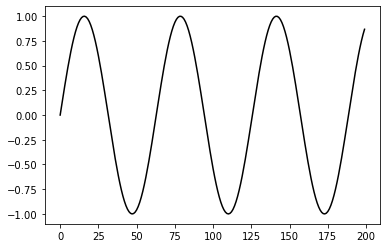

In [4]:
plt.plot(series, c='k')
# plt.savefig('out/plots/sine_wave.png', dpi=600, transparent=True)
plt.show()

Next, we build our dataset. Let's see if we can use $T$ past values to predict the next step value.

In [5]:
T: int = 10  # look-back time steps
X: list = []
Y: list = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N: int = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (190, 10) Y.shape (190,)


Build the autoregressive linear model:

In [6]:
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.1))

half_N: int = N//2

In [7]:
r = model.fit(X[:-half_N], Y[:-half_N],
              epochs=80,
              validation_data=(X[-half_N:], Y[-half_N:]))

Epoch 1/80
3/3 [==============================] - 0s 38ms/step - loss: 3.0265 - val_loss: 0.3748
Epoch 2/80
3/3 [==============================] - 0s 6ms/step - loss: 0.5295 - val_loss: 0.8994
Epoch 3/80
3/3 [==============================] - 0s 7ms/step - loss: 1.2113 - val_loss: 0.8800
Epoch 4/80
3/3 [==============================] - 0s 7ms/step - loss: 0.6409 - val_loss: 0.2117
Epoch 5/80
3/3 [==============================] - 0s 7ms/step - loss: 0.1334 - val_loss: 0.1933
Epoch 6/80
3/3 [==============================] - 0s 7ms/step - loss: 0.3303 - val_loss: 0.2733
Epoch 7/80
3/3 [==============================] - 0s 7ms/step - loss: 0.3107 - val_loss: 0.0812
Epoch 8/80
3/3 [==============================] - 0s 7ms/step - loss: 0.0666 - val_loss: 0.0326
Epoch 9/80
3/3 [==============================] - 0s 7ms/step - loss: 0.0614 - val_loss: 0.1029
Epoch 10/80
3/3 [==============================] - 0s 7ms/step - loss: 0.1135 - val_loss: 0.0446
Epoch 11/80
3/3 [=====================

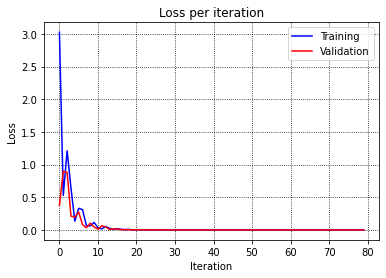

In [8]:
plt.plot(r.history['loss'], label='Training', c='b')
plt.plot(r.history['val_loss'], label='Validation', c='r')
plt.legend()
plt.grid(c='k', ls=':')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title('Loss per iteration')
# plt.savefig('out/plots/loss_per_iteration_ar.png', dpi=600, transparent=True)
plt.show()

## Forecasting the wrong way

"Wrong" forecast using true targets.

Recall that `X` 2D tensor has shape `(N=190, T=10)`.

In [9]:
validation_target = Y[-half_N:]
validation_predictions: list = []

# index of first validation input
i: int = -N//2

while len(validation_predictions) < len(validation_target):
    X_reshaped = X[i].reshape(1, -1)  # From (10,) -> (1, 10)
    p = model.predict(X_reshaped)  # (1, 1)
    p = p[0, 0]  # Extract value
    validation_predictions.append(p)
    i += 1

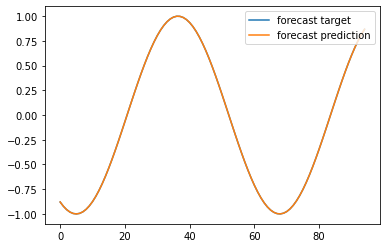

In [10]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
# plt.savefig('out/plots/wrong_ar_cleansine.png', dpi=600, transparent=True)
plt.show()

## Forecasting the correct way

To forecast future values we only use self-predictions for making future predictions.

In [11]:
validation_target = Y[-N//2:]  # (95,)
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1))[0,0]
    validation_predictions.append(p)
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

A simple example to explain what happens in the aforementioned algorithm:

In [12]:
arr = np.array([[1, 2, 3],
                [4, 5, 6]])

last_arr = arr[-1]
last_arr

array([4, 5, 6])

In [13]:
last_arroll = np.roll(last_arr, -1)
last_arroll

array([5, 6, 4])

In [14]:
last_arroll[-1] = 99
last_arroll

array([ 5,  6, 99])

We can now plot our predictions agains the real target:

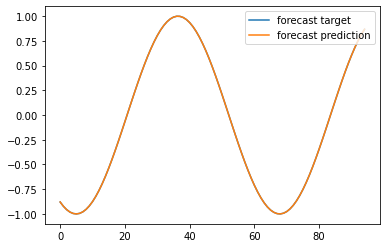

In [15]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
# plt.savefig('out/plots/right_ar_cleansine.png', dpi=600, transparent=True)
plt.show()

# Sine wave with noise

In [16]:
series = np.sin(0.1 * np.arange(200)) + np.random.randn(200) * 0.1

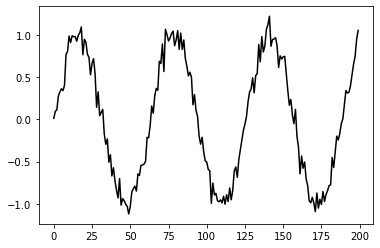

In [17]:
plt.plot(series, c='k')
# plt.savefig('out/plots/noisy_sine_wave.png', dpi=600, transparent=True)
plt.show()

Build the dataset:

In [18]:
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (190, 10) Y.shape (190,)


Buil the AR model using the Functional API:

In [19]:
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.1))

Training the AR model:

In [20]:
r = model.fit(X[:-N//2], Y[:-N//2],
              epochs=80,
              validation_data=(X[-N//2:], Y[-N//2:]),
              verbose=False)

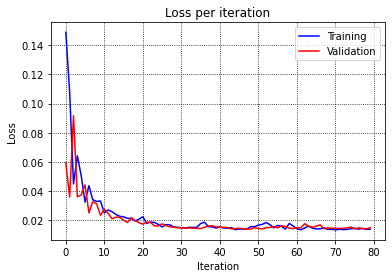

In [21]:
plt.plot(r.history['loss'], label='Training', c='b')
plt.plot(r.history['val_loss'], label='Validation', c='r')
plt.legend()
plt.grid(c='k', ls=':')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title('Loss per iteration')
# plt.savefig('out/plots/loss_per_iteration_noisy_ar.png', dpi=600, transparent=True)
plt.show()

## Forecasting the wrong way

In [22]:
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
    p = model.predict(X[i].reshape(1, -1))[0, 0] # scalar
    i += 1
    
    # update the predictions list
    validation_predictions.append(p)

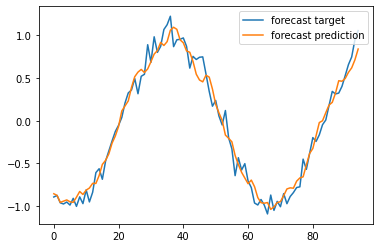

In [23]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
# plt.savefig('out/plots/wrong_ar_noisysine.png', dpi=600, transparent=True)
plt.show()

## Forecasting the correct way

In [24]:
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1))[0,0] # scalar
    validation_predictions.append(p)
    
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

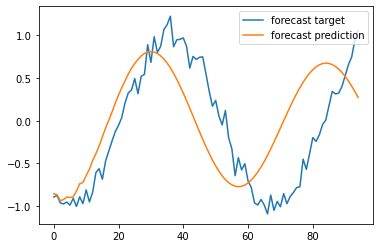

In [25]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
# plt.savefig('out/plots/right_ar_noisysine.png', dpi=600, transparent=True)
plt.show()